In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from assimulo.solvers import IDA
from assimulo.problem import Implicit_Problem
from assimulo.exception import TerminateSimulation

from time import time

%matplotlib inline

Could not find cannot import name 'radau5' from 'assimulo.lib' (C:\Users\moone\Anaconda3\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'dopri5' from 'assimulo.lib' (C:\Users\moone\Anaconda3\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (C:\Users\moone\Anaconda3\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (C:\Users\moone\Anaconda3\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
C:\Users\moone\Anaconda3\lib\site-packages\assimulo\solvers\odepack.py:717: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  38892959/120069679,11804845./141497517]])]
Could not find RADAR5
Could not find GLIMDA.


A square plate with each side having a length of one is initially at 30 degrees except the edges which are held at a fixed temperature.   The top and bottom edges are held at five degrees while the left and right edges are held at zero degrees.  If the diffusion constant $D$ is equal to one, what is the temperature of the plate as a function of position after 10 seconds?

$$
\frac{\partial T}{\partial t} = D\left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2T}{\partial y^2}\right)
$$
with the boundary conditions
$$
T(x = 0, t) = 0 \;\;\mbox{and} \;\; T(x=1, t) = 0
$$
$$
T(y = 0, t) = 5 \;\;\mbox{and} \;\; T(y=1, t) = 5
$$
and with the initial conditions
$$
T(x, y, t = 0) = 30
$$

Text(0.4, 0.5, '$T = 30$')

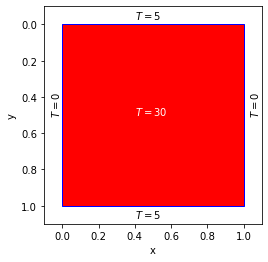

In [2]:
fig, ax = plt.subplots()
rect = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='b', facecolor='r')
ax.add_patch(rect)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()
ax.set_aspect('equal')
plt.text(0.4, 1.07, '$T = 5$')
plt.text(0.4, -0.03, '$T = 5$')
plt.text(-0.07, 0.5, '$T = 0$', rotation = 90)
plt.text(1.03, 0.5, '$T = 0$', rotation = 90)
plt.text(0.4, 0.5, '$T = 30$', color=[1,1,1])

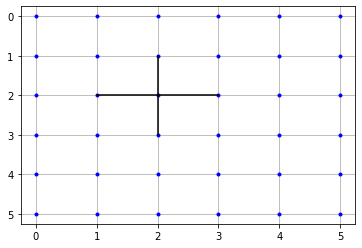

In [3]:
x = np.linspace(0, 1, 6)
y = np.copy(x)
M = x.size; N = y.size

for i in range(N):
    plt.plot(x[i] * 5 * np.ones(N), y * 5, '.b')
plt.grid()
plt.gca().invert_yaxis()

plt.plot((2,1), (2,2), 'k')
plt.plot((2,2), (3,2), 'k')
plt.plot((2,3), (2,2), 'k')
plt.plot((2,2), (1,2), 'k')

circ1 = patches.Circle((2,1), 1.2, linewidth=1, edgecolor='k')
ax.add_patch(circ1)

$$\frac{\partial^2 T}{\partial x^2}  + \frac{\partial^2 T}{\partial y^2} \approx \frac{T_{i-1, j} - 2T_{i,j} + T_{i+1, j}}{(\Delta)^2} + 
\frac{T_{i, j-1} - 2T_{i,j} + T_{i, j+1}}{(\Delta)^2}$$

$$i, j \rightarrow Mj+i$$

In [4]:
class Diffusion:
    def __init__(self):
        self.M = 21
        self.N = self.M
        
        self.x = np.linspace(0, 1, self.M)
        self.y = np.copy(self.x)
        self.Delta = np.diff(x)[0]
        
        T0 = 30 * np.ones(( self.M, self.N) )
        T0[1:-1, 0] = 0
        T0[1:-1, -1] = 0
        T0[0, :] = 5
        T0[-1, :] = 5
        
        T = np.zeros( self.M * self.N )
        for j in range(self.N):
            for i in range(self.M):
                T[ self.return_index_column(i, j) ] = T0[i,j]
                
        Tprime = np.zeros( T.shape )
        
        sw = [False] * T.size
        
        algvar = T.size * [True]
        for j in range(self.N):
            for i in range(self.M):
                if j == 0 or i == 0 or j == self.N-1 or i == self.M - 1:
                    algvar[ self.return_index_column(i, j) ] = False
                    
        #  Create the model object
        model = Implicit_Problem(self.equations, T, Tprime, 0, sw0 = sw)
        
        #  Create the simulation object and pass in the algvar variable.
        sim = IDA(model)
        sim.algvar = algvar
        
        #  Find consistant initial conditions
        sim.make_consistent('IDA_YA_YDP_INIT')
        
        #  Solve the system.
        self.t, self.T, self.Tprime = sim.simulate(10)
                
    def equations(self, t, T, Tprime, sw):
        res = np.zeros(T.shape)
        
        for j in range(1, self.N-1):
            for i in range(1, self.M-1):
                res[ self.return_index_column(i,j) ] = Tprime[ self.return_index_column(i,j) ] - 1 / self.Delta**2 * \
                (-4 * T[self.M*j+i] + T[self.M*(j-1) + i] + T[self.M*(j+1) + i] + \
                T[self.M*j+i-1] + T[self.M*j+i+1])
                
            for i in range(1, self.M-1):
                res[ self.return_index_column(i, 0) ] = T[ self.return_index_column(i, 0) ] - 0
                res[ self.return_index_column(i, self.N-1) ] = T[ self.return_index_column(i, self.N-1) ] - 0
                
            for j in range(self.N):
                res[ self.return_index_column(0, j)] = T[ self.return_index_column(0, j)] - 5
                res[ self.return_index_column(self.M-1, j)] = T[ self.return_index_column(self.M-1, j)] - 5
                
        return res
        
    def return_index_column(self, i, j):
        return self.M*j + i

In [5]:
start = time()
sol = Diffusion()
print(time() - start)

Final Run Statistics: --- 

 Number of steps                                 : 216
 Number of function evaluations                  : 257
 Number of Jacobian evaluations                  : 28
 Number of function eval. due to Jacobian eval.  : 12348
 Number of error test failures                   : 6
 Number of nonlinear iterations                  : 257
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 43.0536198 seconds.
45.97522282600403


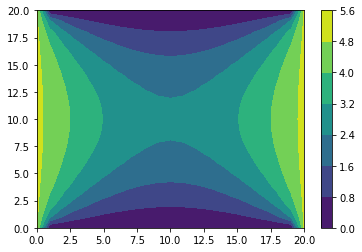

In [6]:
T = sol.T[-1,:]
D = int(np.sqrt(T.size))
T = np.reshape(T, (D, D))
plt.contourf(T)
plt.colorbar()

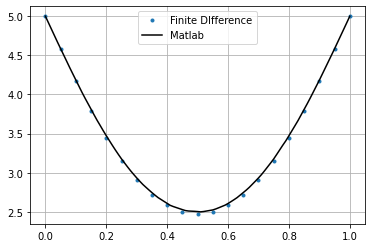

In [16]:
matlab = np.loadtxt('matlab.dat')
plt.plot(np.linspace(0, 1, T[11,:].size), T[11,:],  '.', label = 'Finite DIfference')
plt.plot(np.linspace(0, 1, matlab.size), matlab, 'k', label = 'Matlab')
plt.grid()
plt.legend()